In [2]:
from google.colab import drive
drive.mount('/content/drive')

!pip install distfit
!pip install pandas_market_calendars

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 66.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.8/196.8 kB 10.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_excel("drive/MyDrive/group_project_3_mif/Pro3_Data_Stage1.xlsx")

df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
prices = df["Price"]

In [4]:
str(df.index[0].date())

'2020-01-03'

In [5]:


import pandas_market_calendars as mcal

nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule(start_date=str(df.index[0].date()), end_date=str(df.index[-1].date()))


In [ ]:
# from datetime import timedelta
# discontinue_date = (df.index.diff() != timedelta(days=1)).mean() * 100
# print(f"is_0: {(df.Price == 0).sum()}")
# print(f"isna: {df.Price.isna().mean() * 100:.2f}%")
# print(f"discontinue_date accounts for: {discontinue_date:.2f}%")
# print(f"max of discountinity: {df.index.diff().max().total_seconds() / 86400:.2f} days")
# print(f"min of discountinity: {df.index.diff().min().total_seconds() / 86400:.2f} days")
# print(f"avg of discountinity: {df.index.diff().mean().total_seconds() / 86400:.2f} days")

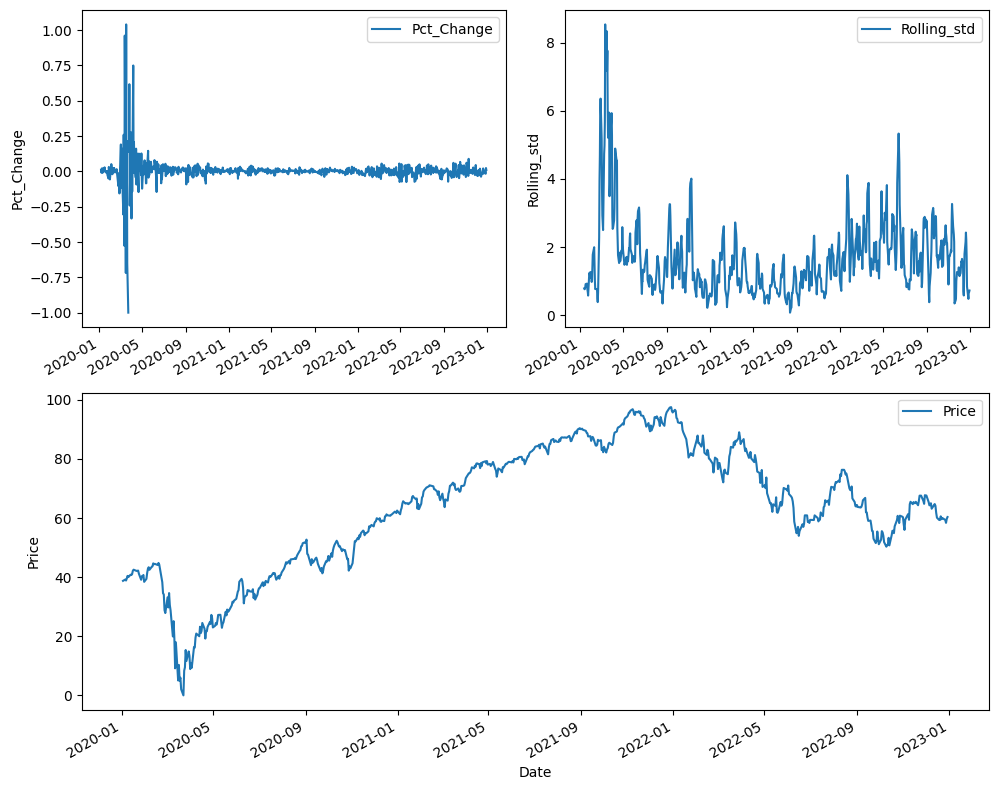

In [6]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])
df.Price.plot(ax=ax1, label="Price")
df.Price.pct_change().plot(ax=ax2, label="Pct_Change")
df.Price.rolling(7).std().plot(ax=ax3, label="Rolling_std")
ax1.legend(), ax2.legend(), ax3.legend()
ax2.set_xlabel(""), ax3.set_xlabel("")
ax1.set_ylabel("Price"), ax2.set_ylabel("Pct_Change"), ax3.set_ylabel("Rolling_std")
plt.tight_layout()
plt.show()


In [7]:
import plotly.express as px
import plotly.graph_objects as go

px.histogram(df.Price.pct_change().fillna(0).replace(np.inf, 0))

In [8]:
from datetime import datetime
time_str = map(lambda time: time.strftime("%Y-%m-%d"), df.loc[df.Price == 0].index)
# df.loc["2020-03-23"] = 1e-6 # still exerts error
df.drop(time_str, axis=0, inplace=True) # Lance: a problem about inf because of the price is 0, so I drop them

# Notes:

The data have fatter tails than a normal distribution implies. We should find a transformation that makes it normal

In [9]:
df.shape

(754, 1)

we are still having fat tails, but we are centered which makes me happy. what do we do about fat tails? we can use box-cox?

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [t       ] [0.03 sec] [RSS: 36.2402] [loc=0.001 scale=0.016]
[distfit] >INFO> [norm    ] [0.00 sec] [RSS: 1336.44] [loc=0.007 scale=0.141]
[distfit] >INFO> [lognorm ] [0.03 sec] [RSS: 1181.91] [loc=-1.260 scale=1.262]
[distfit] >INFO> [loggamma] [0.05 sec] [RSS: 1385.74] [loc=-71.847 scale=8.890]
[distfit] >INFO> [t       ] [0.13 sec] [RSS: 36.2402] [loc=0.001 scale=0.016]
[distfit] >INFO> [norm    ] [0.09 sec] [RSS: 1336.44] [loc=0.007 scale=0.141]
[distfit] >INFO> [lognorm ] [0.09 sec] [RSS: 1181.91] [loc=-1.260 scale=1.262]
[distfit] >INFO> [loggamma] [0.06 sec] [RSS: 1385.74] [loc=-71.847 scale=8.890]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: T(loc:0.001485, scale:0.015692)
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [t      ] [0.09 sec] [RSS: 42.0793] [loc=0.002 scale=0.016]
[dist

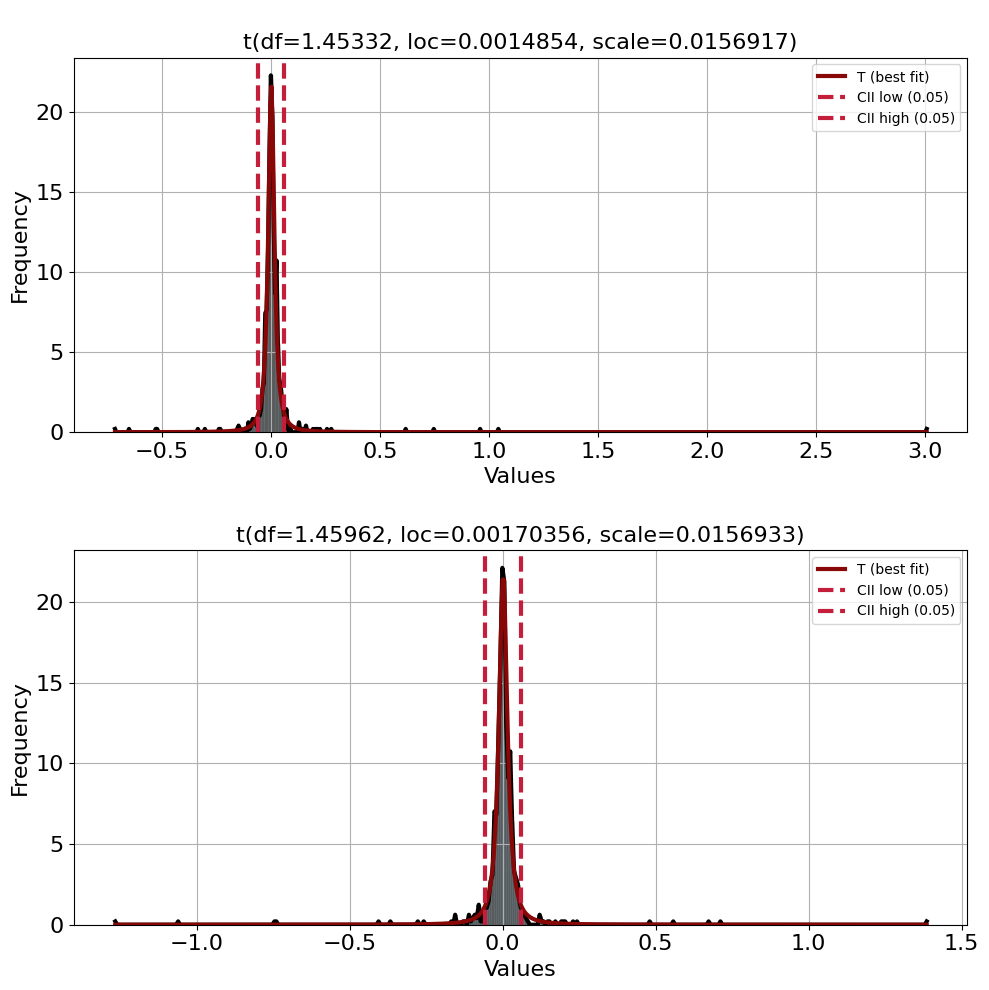

In [10]:
from distfit import distfit
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2, figure=plt.gcf())
ax1 = plt.gcf().add_subplot(gs[0:2,:])
ax2 = plt.gcf().add_subplot(gs[2:4,:])

fit = distfit(distr=["t", "norm", "lognorm", "loggamma"])
fit.fit_transform(df.Price.pct_change().dropna())
fit.plot(figsize=(8, 5), ax=ax1)

df["returns"] = df.Price.pct_change()
df["log_ret"] = np.log(1 + df["returns"])
df.dropna(inplace=True)

fit = distfit(distr=["t", "uniform", "norm", "lognorm"])
fit.fit_transform(df.log_ret)
fit.plot(figsize=(8, 5), ax=ax2)

plt.tight_layout()
plt.show()

In [11]:
from scipy import stats

# use box-cox to normalize df["returns"]

def transform_returns(df, returns_col="log_ret"):
    """
    Calculate returns and apply Box-Cox transformation to normalize the series.

    Parameters:
    df (pandas.DataFrame): DataFrame with 'Price' column and datetime index

    Returns:
    tuple: (transformed_returns, lambda_param)
        - transformed_returns: Box-Cox transformed returns series
        - lambda_param: optimal lambda parameter from Box-Cox transformation
    """
    returns = df[returns_col].dropna()
    shift_constant = abs(returns.min()) + 1e-6  # Small epsilon to ensure strict positivity
    shifted_returns = returns + shift_constant

    transformed_data, lambda_param = stats.boxcox(shifted_returns)

    transformed_returns = pd.Series(transformed_data, index=returns.index)

    return transformed_returns, lambda_param, shift_constant

def inverse_transform_returns(transformed_returns, lambda_param, original_shift):
    """
    Inverse transform the Box-Cox transformed returns back to original scale.

    Parameters:
    transformed_returns: Box-Cox transformed returns
    lambda_param: lambda parameter from Box-Cox transformation
    original_shift: The shift applied to make returns positive

    Returns:
    pandas.Series: Original scale returns
    """
    if lambda_param == 0:
        original_returns = np.exp(transformed_returns)
    else:
        original_returns = np.power(transformed_returns * lambda_param + 1, 1/lambda_param)

    original_returns = original_returns - original_shift

    return original_returns

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 1596.05] [loc=-0.779 scale=2.734]
[distfit] >INFO> [norm   ] [0.00 sec] [RSS: 1046.35] [loc=0.281 scale=0.112]
[distfit] >INFO> [t      ] [0.09 sec] [RSS: 36.6632] [loc=0.281 scale=0.017]
[distfit] >INFO> [uniform] [0.10 sec] [RSS: 1596.05] [loc=-0.779 scale=2.734]
[distfit] >INFO> [norm   ] [0.10 sec] [RSS: 1046.35] [loc=0.281 scale=0.112]
[distfit] >INFO> [t      ] [0.10 sec] [RSS: 36.6632] [loc=0.281 scale=0.017]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: T(loc:0.281080, scale:0.016825)


(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': '\nt(df=1.46477, loc=0.28108, scale=0.0168245)'}, xlabel='Values', ylabel='Frequency'>)

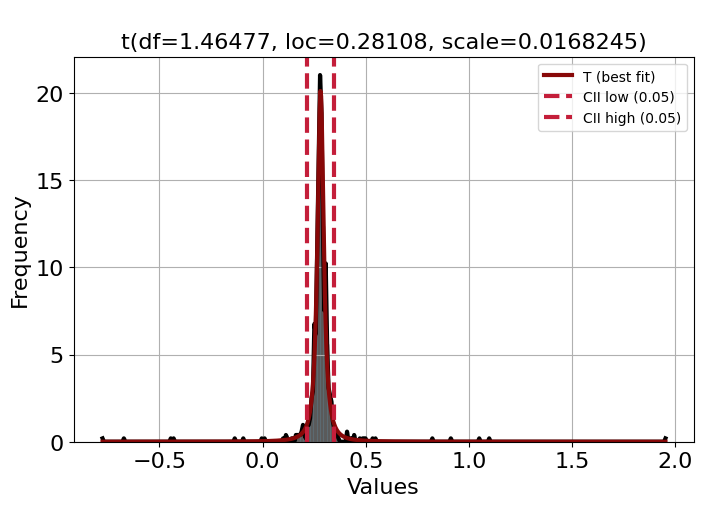

In [12]:
whole_log_return, lambda_train, shift_constant_train = transform_returns(df)
fit = distfit(distr=["uniform", "norm", "t"])
fit.fit_transform(whole_log_return.dropna())
fit.plot(figsize=(8, 5))

In [16]:
oos = pd.read_excel("drive/MyDrive/group_project_3_mif/Pro3_Data_Stage2.xlsx")

oos["Date"] = pd.to_datetime(oos["Date"])
oos = oos.set_index("Date")

In [17]:
oos

,Price
Date,
2020-01-03,38.744164
2020-01-06,39.188201
2020-01-07,38.854328
2020-01-08,39.533819
2020-01-09,40.416625
...,...
2023-12-22,95.338131
2023-12-26,95.776835
2023-12-27,95.867802


In [18]:
def calculate_rsi(prices, window=14):
    """
    Calculate the Relative Strength Index (RSI) for a price series.

    Parameters:
    prices (pd.Series): The price series.
    window (int): The lookback period for calculating RSI (default is 14).

    Returns:
    pd.Series: The RSI values.
    """
    # Compute price changes
    price_changes = prices.diff()

    # Separate gains and losses
    gains = price_changes.where(price_changes > 0, 0)
    losses = abs(price_changes.where(price_changes < 0, 0))  # Take absolute value of losses

    # Calculate average gains and losses using rolling mean
    avg_gains = gains.rolling(window=window, min_periods=1).mean()
    avg_losses = losses.rolling(window=window, min_periods=1).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gains / avg_losses

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
    """
    Calculate the Moving Average Convergence Divergence (MACD) for a price series.

    Parameters:
    prices (pd.Series): The price series.
    short_window (int): The short-term EMA period (default is 12).
    long_window (int): The long-term EMA period (default is 26).
    signal_window (int): The signal line EMA period (default is 9).

    Returns:
    pd.DataFrame: A DataFrame containing the MACD line, Signal line, and MACD Histogram.
    """
    # Calculate short-term EMA
    ema_short = prices.ewm(span=short_window, adjust=False).mean()

    # Calculate long-term EMA
    ema_long = prices.ewm(span=long_window, adjust=False).mean()

    # Calculate MACD line
    macd_line = ema_short - ema_long

    # Calculate Signal line
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

    # Calculate MACD Histogram
    macd_histogram = macd_line - signal_line

    # Combine into a DataFrame
    macd_df = pd.DataFrame({
        'macd_line': macd_line,
        'signal_line': signal_line,
        # 'macd_hist': macd_histogram
    })
    return macd_df


df["rsi"] = calculate_rsi(df.Price)
df[["macd_line", "macd_signal"]] = calculate_macd(df.Price)
df["ema_12"] = df.Price.ewm(span=12, adjust=False).mean()
df["ema_26"] = df.Price.ewm(span=26, adjust=False).mean()
df["ma_10"] = df.Price.rolling(10).mean()
df["ma_20"] = df.Price.rolling(20).mean()
df["rolling_vol"] = df["log_ret"].rolling(window=11).std()

df["rsi_signal"] = np.where(df["rsi"] > 70, -1, np.where(df["rsi"] < 30, 1, 0))
df["macd_signal"] = np.where(df["macd_line"] > df["macd_signal"], 1, -1)

# df = df.drop(columns=["Price", "returns", "log_ret"])

df.head()

,Price,returns,log_ret,rsi,macd_line,macd_signal,ema_12,ema_26,ma_10,ma_20,rolling_vol,rsi_signal
Date,,,,,,,,,,,,
2020-01-06,39.188201,0.011461,0.011396,NaN,0.000000,-1,39.188201,39.188201,NaN,NaN,NaN,0
2020-01-07,38.854328,-0.008520,-0.008556,0.000000,-0.026634,-1,39.136836,39.163470,NaN,NaN,NaN,1
2020-01-08,39.533819,0.017488,0.017337,67.053012,0.007007,1,39.197910,39.190903,NaN,NaN,NaN,0
2020-01-09,40.416625,0.022330,0.022085,82.392234,0.103708,1,39.385405,39.281697,NaN,NaN,NaN,-1
2020-01-10,39.994919,-0.010434,-0.010489,67.402097,0.144648,1,39.479176,39.334528,NaN,NaN,NaN,0


In [19]:
oos["returns"] = oos.Price.pct_change()
oos["log_ret"] = np.log(1 + oos["returns"])
oos["rsi"] = calculate_rsi(oos.Price)
oos[["macd_line", "macd_signal"]] = calculate_macd(oos.Price)
oos["ema_12"] = oos.Price.ewm(span=12, adjust=False).mean()
oos["ema_26"] = oos.Price.ewm(span=26, adjust=False).mean()
oos["ma_10"] = oos.Price.rolling(10).mean()
oos["ma_20"] = oos.Price.rolling(20).mean()
oos["rolling_vol"] = oos["log_ret"].rolling(window=11).std()

oos["rsi_signal"] = np.where(oos["rsi"] > 70, -1, np.where(oos["rsi"] < 30, 1, 0))
oos["macd_signal"] = np.where(oos["macd_line"] > oos["macd_signal"], 1, -1)
oos["boxcox_log_ret"], lambda_oos, shift_constant_oos = transform_returns(oos)
oos_X = oos.drop(columns=["Price", "returns", "log_ret"])

In [20]:
oos

,Price,returns,log_ret,rsi,macd_line,macd_signal,ema_12,ema_26,ma_10,ma_20,rolling_vol,rsi_signal,boxcox_log_ret
Date,,,,,,,,,,,,,
2020-01-03,38.744164,NaN,NaN,NaN,0.000000,-1,38.744164,38.744164,NaN,NaN,NaN,0,NaN
2020-01-06,39.188201,0.011461,0.011396,100.000000,0.035422,1,38.812478,38.777056,NaN,NaN,NaN,-1,0.288119
2020-01-07,38.854328,-0.008520,-0.008556,57.080737,0.036136,1,38.818916,38.782780,NaN,NaN,NaN,0,0.267212
2020-01-08,39.533819,0.017488,0.017337,77.091201,0.090489,1,38.928901,38.838412,NaN,NaN,NaN,-1,0.294357
2020-01-09,40.416625,0.022330,0.022085,85.733176,0.202465,1,39.157782,38.955317,NaN,NaN,NaN,-1,0.299346
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,95.338131,-0.000587,-0.000587,79.656281,3.233741,1,93.179566,89.945826,93.904160,90.950408,0.010969,-1,0.275555
2023-12-26,95.776835,0.004602,0.004591,80.105625,3.201394,1,93.579146,90.377752,94.410004,91.401709,0.010930,-1,0.280981
2023-12-27,95.867802,0.000950,0.000949,82.299421,3.146824,1,93.931247,90.784423,94.836156,91.852788,0.011010,-1,0.277165


In [21]:
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

def apply_boxcox(data, lambda_val, shift_constant):
    # Box-Cox
    return np.log(data + shift_constant) / lambda_val if lambda_val != 0 else np.log(data + shift_constant)

temp = df.copy()
# temp[["tomorrow_log_ret", "tomorrow_Price", "tomorrow_returns"]] = temp[["log_ret", "Price", "returns"]].shift(-1)
# temp = temp.dropna()

train_date = pd.to_datetime("2022-01-01")

training_set = temp.loc[:train_date]
testing_set = temp.loc[train_date + timedelta(days=1):]

training_set["boxcox_log_ret"], lambda_training_set, shift_constant_training_set = transform_returns(training_set)
testing_set["boxcox_log_ret"] = apply_boxcox(
    testing_set["log_ret"],
    lambda_training_set,
    shift_constant_training_set
)

training_set["tomorrow_boxcox_log_ret"] = training_set["boxcox_log_ret"].shift(-1)
testing_set["tomorrow_boxcox_log_ret"] = testing_set["boxcox_log_ret"].shift(-1)

training_set = training_set.dropna().drop(columns=["Price", "returns", "log_ret"])
testing_set = testing_set.dropna().drop(columns=["Price", "returns", "log_ret"])

train_x = training_set.drop(columns=["tomorrow_boxcox_log_ret"])
train_y = training_set["tomorrow_boxcox_log_ret"]

test_x = testing_set.drop(columns=["tomorrow_boxcox_log_ret"])
test_y = testing_set["tomorrow_boxcox_log_ret"]

<Axes: ylabel='Frequency'>

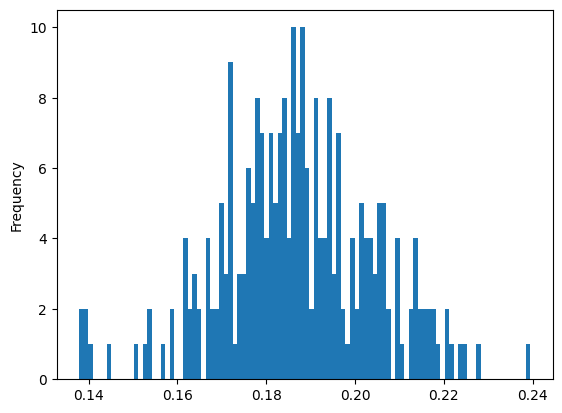

In [22]:
testing_set["boxcox_log_ret"].plot(kind="hist", bins=100)

In [ ]:
# Bayesian_Ridge & RF
ridge = BayesianRidge(fit_intercept=True, tol=1e-3, alpha_1=1e-6, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-6)
ridge.fit(train_x, train_y)
ridge_pred, ridge_std_pred = ridge.predict(test_x, return_std=True)

rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4, n_jobs=-1)
rf.fit(train_x, train_y)
rf_pred = rf.predict(test_x)

# arima = ARIMA(y_train.values, X_train.values, (0, 3, 3)).fit()
# arima_pred = arima.predict(X_test.values)

# SVR
from sklearn.svm import SVR
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1, max_iter=-1)
svr.fit(train_x, train_y)
svr_pred = svr.predict(test_x)
# svr_oos = svr.predict(oos_X)

# Ensemble
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor

gbr = GradientBoostingRegressor(n_estimators=100, random_state=89)
stack = StackingRegressor(
    estimators=[
        ('rf', rf),
        ('ridge', ridge),
        ('gbr', gbr)
    ],
    final_estimator=ridge
)
stack.fit(train_x, train_y)
ensemble_pred = stack.predict(test_x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


<Axes: >

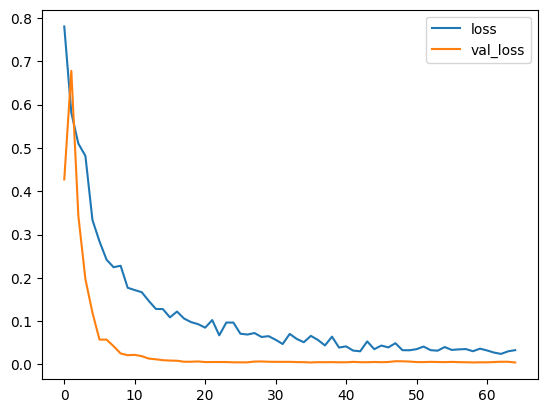

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.clear_session()

early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=40,
    restore_best_weights=True
)

model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=(train_x.shape[1],)))
model.add(layers.Dense(32))
model.add(layers.Dropout(0.2))
model.add(layers.LeakyReLU(alpha=0.01))

model.add(layers.BatchNormalization())
model.add(layers.Dense(32))
model.add(layers.Dropout(0.2))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.Dense(1))

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_x,
    train_y,
    validation_data=(test_x, test_y),
    epochs=100,
    batch_size=32,
    verbose=False,
    callbacks=[early_stopping]
    )
mnn_pred = model.predict(test_x)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ["loss", "val_loss"]].plot()

In [ ]:
train_x.tail()

,rsi,macd_line,macd_signal,ema_12,ema_26,ma_10,ma_20,rolling_vol,rsi_signal,boxcox_log_ret
Date,,,,,,,,,,
2021-12-23,65.985980,0.369621,1,93.484850,93.115229,93.313194,92.519326,0.017316,0,0.284126
2021-12-27,65.065154,0.648491,1,94.075473,93.426982,93.606992,92.840487,0.017751,0,0.292248
2021-12-28,60.218097,0.868471,1,94.592363,93.723891,94.086367,93.106289,0.017740,0,0.276552
2021-12-29,60.133370,1.036281,1,95.040062,94.003782,94.722643,93.467778,0.016290,0,0.276079
2021-12-30,56.721878,1.049695,1,95.213972,94.164278,94.924512,93.810191,0.015972,0,0.261045


In [ ]:
test_x.head()

,rsi,macd_line,macd_signal,ema_12,ema_26,ma_10,ma_20,rolling_vol,rsi_signal,boxcox_log_ret
Date,,,,,,,,,,
2022-01-03,62.032510,1.041600,1,95.492759,94.451160,95.626152,94.381029,0.012719,0,0.210039
2022-01-04,66.535617,1.022871,1,95.605440,94.582569,96.129777,94.608661,0.012238,0,0.201035
2022-01-05,48.902644,0.805296,-1,95.331955,94.526659,96.152013,94.596591,0.014508,0,0.186593
2022-01-06,51.700754,0.605460,-1,95.061600,94.456140,96.013596,94.566756,0.012256,0,0.201910
2022-01-07,50.469098,0.343002,-1,94.641925,94.298923,95.670895,94.492044,0.011844,0,0.194704


In [ ]:
# # ### Scoring

def convert_boxcox_pred_to_price(pred_returns, price_series):
    returns_space = inverse_transform_returns(pred_returns, lambda_training_set, shift_constant_training_set)  # convert from boxcox to actual returns space
    linear_returns = np.exp(returns_space) - 1 # log to linear
    pred_price = (1 + linear_returns) * price_series  # predict price
    return pred_price

ridge_price_pred = convert_boxcox_pred_to_price(ridge_pred, test_y)
rf_price_pred = convert_boxcox_pred_to_price(rf_pred, test_y)


In [ ]:
# ### Scoring

def convert_boxcox(pred_returns, lambda_, shift_constant):
    returns_space = inverse_transform_returns(pred_returns, lambda_, shift_constant)  # convert from boxcox to actual returns space
    return returns_space

def get_pred_price(pred_log_returns, price):
    pred_price = np.cumsum(pred_log_returns) * price
    return pred_price

In [ ]:
oos_X = oos_X.dropna()

In [ ]:
oos

,Price,returns,log_ret,rsi,macd_line,macd_signal,ema_12,ema_26,ma_10,ma_20,rolling_vol,rsi_signal,boxcox_log_ret
Date,,,,,,,,,,,,,
2020-01-03,38.744164,NaN,NaN,NaN,0.000000,-1,38.744164,38.744164,NaN,NaN,NaN,0,NaN
2020-01-06,39.188201,0.011461,0.011396,100.000000,0.035422,1,38.812478,38.777056,NaN,NaN,NaN,-1,0.288119
2020-01-07,38.854328,-0.008520,-0.008556,57.080737,0.036136,1,38.818916,38.782780,NaN,NaN,NaN,0,0.267212
2020-01-08,39.533819,0.017488,0.017337,77.091201,0.090489,1,38.928901,38.838412,NaN,NaN,NaN,-1,0.294357
2020-01-09,40.416625,0.022330,0.022085,85.733176,0.202465,1,39.157782,38.955317,NaN,NaN,NaN,-1,0.299346
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,95.338131,-0.000587,-0.000587,79.656281,3.233741,1,93.179566,89.945826,93.904160,90.950408,0.010969,-1,0.275555
2023-12-26,95.776835,0.004602,0.004591,80.105625,3.201394,1,93.579146,90.377752,94.410004,91.401709,0.010930,-1,0.280981
2023-12-27,95.867802,0.000950,0.000949,82.299421,3.146824,1,93.931247,90.784423,94.836156,91.852788,0.011010,-1,0.277165


In [ ]:
oos_actual = convert_boxcox(oos["boxcox_log_ret"], lambda_training_set, shift_constant_training_set)
ridge_oos_pred = convert_boxcox(ridge.predict(oos_X), lambda_training_set, shift_constant_training_set)
rf_oos_pred = convert_boxcox(rf.predict(oos_X), lambda_training_set, shift_constant_training_set)
mnn_oos_pred = convert_boxcox(model.predict(oos_X), lambda_training_set, shift_constant_training_set)
svr_oos_pred = convert_boxcox(svr.predict(oos_X), lambda_training_set, shift_constant_training_set)
ensemble_oos_pred = convert_boxcox(stack.predict(oos_X), lambda_training_set, shift_constant_training_set)

ridge_log_return_pred = convert_boxcox(ridge_pred, lambda_training_set, shift_constant_training_set)
rf_log_return_pred = convert_boxcox(rf_pred, lambda_training_set, shift_constant_training_set)
mnn_log_return_pred = convert_boxcox(mnn_pred.flatten(), lambda_training_set, shift_constant_training_set)
ensemble_log_return_pred = convert_boxcox(ensemble_pred, lambda_training_set, shift_constant_training_set)
svr_log_return_pred = convert_boxcox(svr_pred, lambda_training_set, shift_constant_training_set)

last_index = df.index.get_loc(test_y.index[0]) - 1
last_price = df.iloc[last_index].Price

ridge_price_pred = get_pred_price(ridge_log_return_pred, last_price)
rf_price_pred = get_pred_price(rf_log_return_pred, last_price)
mnn_price_pred = get_pred_price(mnn_log_return_pred, last_price)
ensemble_price_pred = get_pred_price(ensemble_log_return_pred, last_price)
svr_price_pred = get_pred_price(svr_log_return_pred, last_price)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
train_oos

,Price,returns,log_ret,rsi,macd_line,macd_signal,ema_12,ema_26,ma_10,ma_20,rolling_vol,rsi_signal,boxcox_log_ret
Date,,,,,,,,,,,,,
2020-01-31,38.404335,-0.057044,-0.058736,42.345641,0.193639,-1,40.366346,40.172707,40.901137,40.520213,0.028959,0,0.214918
2020-02-03,39.410934,0.026211,0.025873,43.364890,0.103081,-1,40.219360,40.116279,40.590683,40.553552,0.028713,0,0.303329
2020-02-04,41.433948,0.051331,0.050057,52.850731,0.192335,-1,40.406219,40.213884,40.525099,40.665839,0.033199,0,0.328811
2020-02-05,42.861784,0.034461,0.033880,56.879343,0.373974,1,40.783998,40.410025,40.597945,40.866212,0.034784,0,0.311755
2020-02-06,43.342986,0.011227,0.011164,54.610364,0.550408,1,41.177689,40.627281,40.710102,41.056670,0.034899,0,0.287876
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,60.009809,0.006994,0.006970,29.704952,-0.917770,-1,61.484723,62.402494,61.385793,63.467680,0.019494,1,0.283476
2022-12-27,59.355708,-0.010900,-0.010960,30.724772,-1.019623,-1,61.157183,62.176806,60.885519,63.145591,0.018208,0,0.264698
2022-12-28,58.356754,-0.016830,-0.016973,28.180996,-1.167492,-1,60.726348,61.893839,60.249418,62.823523,0.016482,1,0.258412


In [ ]:
import datetime as dt

train_oos = oos[oos.index < "2023-01-01"].dropna()
test_oos = oos[oos.index >= "2023-01-01"].dropna()

# I want to retrain my model every 10 intervals
cols_to_drop = ["Price", "returns", "log_ret", "boxcox_log_ret"]
rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4, n_jobs=-1)
rf.fit(train_oos.drop(columns=cols_to_drop), train_oos["log_ret"])


svm = SVR(kernel='rbf', C=1.0, epsilon=0.1, max_iter=-1)
svm.fit(train_oos.drop(columns=cols_to_drop), train_oos["log_ret"])

ridge = Ridge(alpha=1.0)
ridge.fit(train_oos.drop(columns=cols_to_drop), train_oos["log_ret"])

gbr = GradientBoostingRegressor(n_estimators=100, random_state=89)
stack = StackingRegressor(
    estimators=[
        ('rf', rf),
        ('ridge', ridge),
        ('gbr', gbr)
    ],
    final_estimator=ridge
)
stack.fit(train_oos.drop(columns=cols_to_drop), train_oos["log_ret"])

preds = {
    "ts": [],
    "rf": [],
    "svm": [],
    "ridge": [],
    "gbr": [],
    "act": []
}
for i in range(len(test_oos)):
  preds["ts"].append(train_oos.iloc[i].index[0])
  if i > 0 and i % 10 == 0:
    test_oos_2 = oos[oos.index >= pd.Timestamp("2023-01-01") + dt.timedelta(days=i)].dropna()
    train_oos_2 = oos[oos.index < pd.Timestamp("2023-01-01") + dt.timedelta(days=i)].dropna()
    train_X = train_oos_2.drop(columns=cols_to_drop)
    train_y = train_oos_2["log_ret"]
    rf.fit(train_X, train_y)
    svm.fit(train_X, train_y)
    ridge.fit(train_X, train_y)
    stack.fit(train_X, train_y)
  rf_pred = rf.predict(test_oos.drop(columns=cols_to_drop).iloc[i].values.reshape(1, -1))
  svm_pred = svm.predict(test_oos.drop(columns=cols_to_drop).iloc[i].values.reshape(1, -1))
  ridge_pred = ridge.predict(test_oos.drop(columns=cols_to_drop).iloc[i].values.reshape(1, -1))
  gbr_pred = stack.predict(test_oos.drop(columns=cols_to_drop).iloc[i].values.reshape(1, -1))
  preds["rf"].append(rf_pred)
  preds["svm"].append(svm_pred)
  preds["ridge"].append(ridge_pred)
  preds["gbr"].append(gbr_pred)
  preds["act"].append(test_oos["log_ret"].iloc[i])




In [ ]:
preds = pd.DataFrame(preds)
preds.index = test_oos.index
for col in preds.columns:
  if isinstance(preds[col].iloc[0], np.ndarray):
    preds[col] = preds[col].apply(lambda x: x[0])

preds = preds.drop(columns=["ts"])

,ts,rf,svm,ridge,gbr,act
Date,,,,,,
2023-01-03,P,-0.000037,-0.000402,0.006453,-0.000685,-0.006331
2023-01-04,P,0.004465,0.003129,0.007799,0.001596,0.015544
2023-01-05,P,-0.001817,0.002119,0.006347,0.000934,-0.013308
2023-01-06,P,0.003475,0.022785,-0.000483,0.001696,0.043406
2023-01-09,P,0.006253,0.028797,0.004397,0.002278,0.002647
...,...,...,...,...,...,...
2023-12-22,P,-0.004481,0.017674,0.006344,0.000631,-0.000587
2023-12-26,P,-0.003960,0.017165,0.004087,0.000527,0.004591
2023-12-27,P,-0.003502,0.016336,0.002262,0.000453,0.000949


In [ ]:
import plotly.graph_objects as go

original_log_return_test = df.loc[test_y.index].log_ret
original_prices_test = df.loc[test_y.index].Price

fig = go.Figure()
fig.add_trace(go.Scatter(x=preds.index, y=preds["act"], name="Real Return"))
# fig.add_trace(go.Scatter(x=test_x.index, y=actual_prices, name="Price Obs"))
fig.add_trace(go.Scatter(x=preds.index, y=preds["ridge"], name="Ridge Return Pred"))
fig.add_trace(go.Scatter(x=preds.index, y=preds["rf"], name="RF Return Pred"))
# fig.add_trace(go.Scatter(x=preds.index, y=mnn_oos_pred, name="MNN Return Pred"))
fig.add_trace(go.Scatter(x=preds.index, y=preds["gbr"], name="GB Return Pred"))
# fig.add_trace(go.Scatter(x=preds.index, y=preds["svr"], name="SVR Return Pred"))

fig.update_layout(title="Return Observations and Predictions",
                  xaxis_title="Date",
                  yaxis_title="Log_Return")

fig.show()

In [ ]:
oos_X

,rsi,macd_line,macd_signal,ema_12,ema_26,ma_10,ma_20,rolling_vol,rsi_signal,boxcox_log_ret
Date,,,,,,,,,,
2020-01-31,42.345641,0.193639,-1,40.366346,40.172707,40.901137,40.520213,0.028959,0,0.214918
2020-02-03,43.364890,0.103081,-1,40.219360,40.116279,40.590683,40.553552,0.028713,0,0.303329
2020-02-04,52.850731,0.192335,-1,40.406219,40.213884,40.525099,40.665839,0.033199,0,0.328811
2020-02-05,56.879343,0.373974,1,40.783998,40.410025,40.597945,40.866212,0.034784,0,0.311755
2020-02-06,54.610364,0.550408,1,41.177689,40.627281,40.710102,41.056670,0.034899,0,0.287876
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,79.656281,3.233741,1,93.179566,89.945826,93.904160,90.950408,0.010969,-1,0.275555
2023-12-26,80.105625,3.201394,1,93.579146,90.377752,94.410004,91.401709,0.010930,-1,0.280981
2023-12-27,82.299421,3.146824,1,93.931247,90.784423,94.836156,91.852788,0.011010,-1,0.277165


In [ ]:
oos_X[oos_X.index.year == 2023]


,rsi,macd_line,macd_signal,ema_12,ema_26,ma_10,ma_20,rolling_vol,rsi_signal,boxcox_log_ret
Date,,,,,,,,,,
2023-01-03,32.188194,-1.059647,-1,60.445601,61.505247,59.655355,61.687501,0.016182,0,0.269541
2023-01-04,35.221344,-0.945994,-1,60.513411,61.459404,59.811228,61.462560,0.014913,0,0.292474
2023-01-05,34.660058,-0.910379,-1,60.446955,61.357333,59.886097,61.252056,0.014933,0,0.262242
2023-01-06,53.822767,-0.659483,1,60.800771,61.460254,60.104162,61.171742,0.019606,0,0.321793
2023-01-09,61.687664,-0.442131,1,61.125738,61.567869,60.436168,61.067635,0.018923,0,0.278943
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,79.656281,3.233741,1,93.179566,89.945826,93.904160,90.950408,0.010969,-1,0.275555
2023-12-26,80.105625,3.201394,1,93.579146,90.377752,94.410004,91.401709,0.010930,-1,0.280981
2023-12-27,82.299421,3.146824,1,93.931247,90.784423,94.836156,91.852788,0.011010,-1,0.277165


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def score_model(actual, pred):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return {"mae": mae, "r2": r2}


# print("R2_SCORE:")
print("bayesian_param_grid:", score_model(preds["ridge"], preds["act"]))
print("random_forest_grid:", score_model(preds["rf"], preds["act"]))
# print("mmn: ", score_model(mnn_return_pred, y_test).get("r2"))
print("Gradient_Boosting_Regressor", score_model(preds["gbr"], preds["act"]))
print("svr", score_model(preds["svm"], preds["act"]))

bayesian_param_grid: {'mae': 0.011963397482450401, 'r2': -0.9837595824165071}
random_forest_grid: {'mae': 0.010987934251976082, 'r2': -5.845773728534434}
Gradient_Boosting_Regressor {'mae': 0.010935139152304978, 'r2': -35.81091080987376}
svr {'mae': 0.023304843178323858, 'r2': -14.89729312155725}


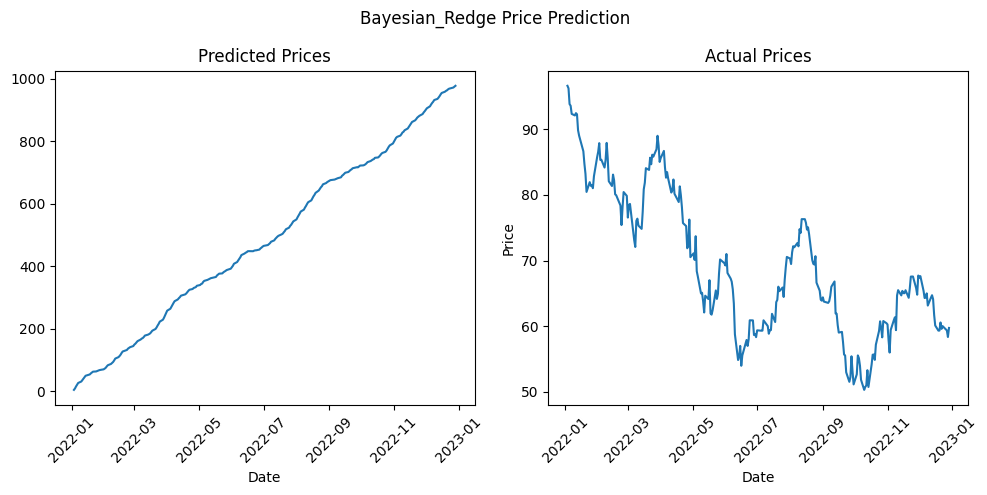

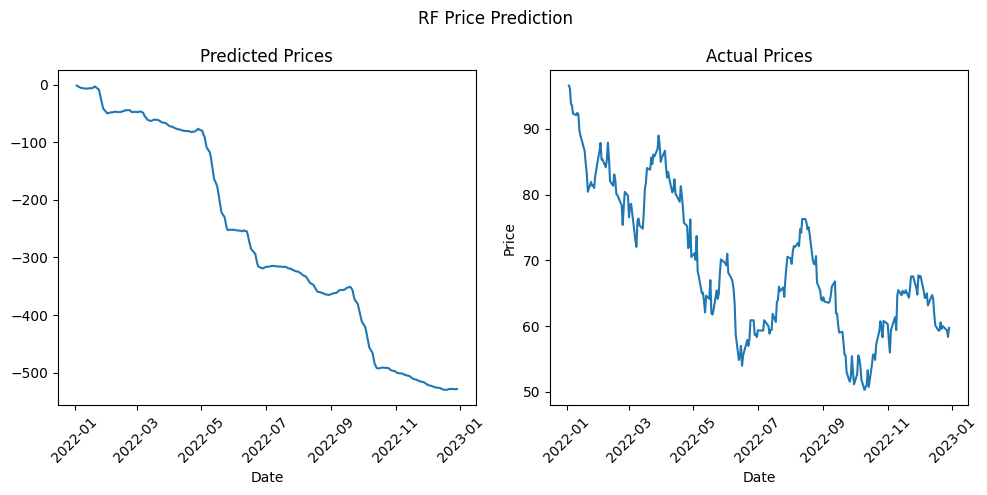

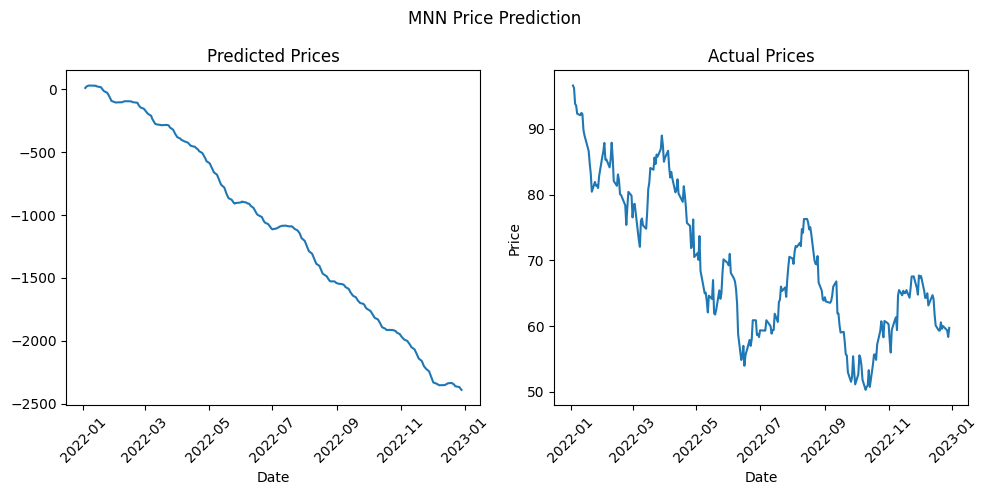

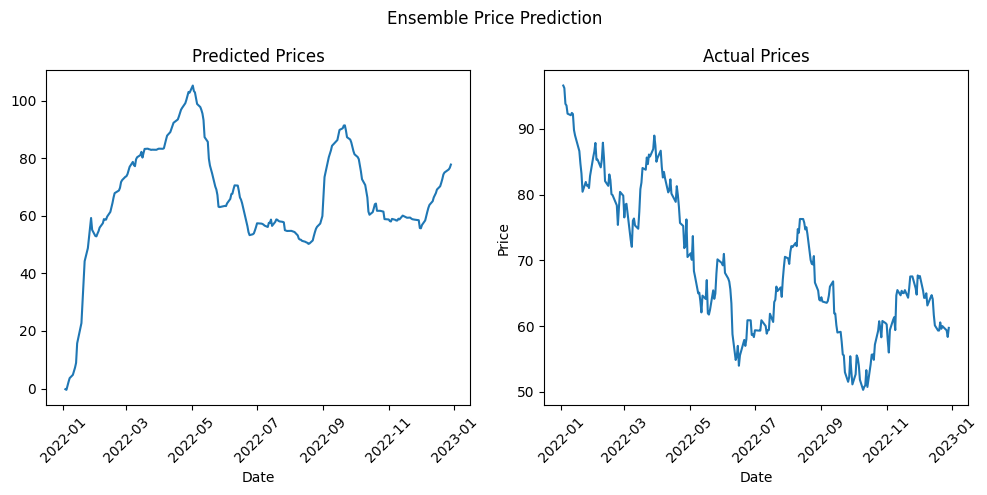

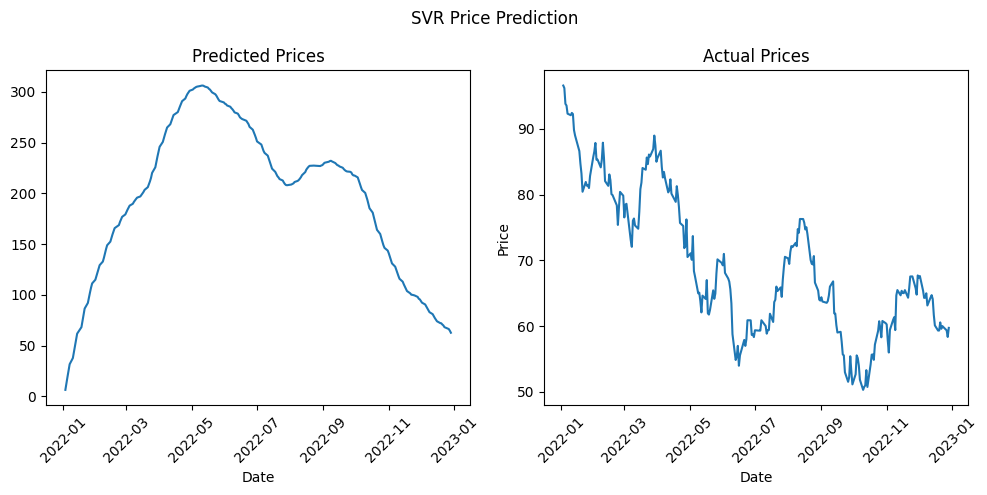

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

prices_oos = temp.Price[test_x.index]

def plot_predictions(pred, title, temp, closest_):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(title)

    sns.lineplot(x=test_x.index, y=pred, ax=ax1)
    ax1.set_title("Predicted Prices")
    ax1.tick_params(axis='x', rotation=45)

    sns.lineplot(x=test_x.index, y=temp.Price.loc[test_x.index], ax=ax2)
    ax2.set_title("Actual Prices")
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plot_predictions(ridge_price_pred, "Bayesian_Redge Price Prediction", temp, last_index)
plot_predictions(rf_price_pred, "RF Price Prediction", temp, last_index)
plot_predictions(mnn_price_pred, "MNN Price Prediction", temp, last_index)
plot_predictions(ensemble_price_pred, "Ensemble Price Prediction", temp, last_index)
plot_predictions(svr_price_pred, "SVM Price Prediction", temp, last_index)

## TODO:

First we need our signals. we build features and predict the direction of the trade

Next we have an ``Account()`` class that manages the portfolio

Then, given the signal, we use linopy

In [ ]:
ridge_std_pred

,0
Date,
2022-01-03,0.123501
2022-01-04,0.124875
2022-01-05,0.121922
2022-01-06,0.122681
2022-01-07,0.122672
...,...
2022-12-22,0.120988
2022-12-23,0.122319
2022-12-27,0.118566


In [ ]:
from attrs import field, define

@define(frozen=False, auto_attribs=True)
class Account:
  balance: int = 10_000
  share_count: int = 0
  trades: list[Trade] = field(factory=list)

  def __attrs_post_init__(self):
    self.account_value = self.balance
    self.balance_history = [self.balance]
    self.account_value_history = [self.account_value]
    self.portfolio_history = [self.share_count]


  def buy(self, price, shares):
    self.balance -= price * shares
    self.share_count += shares
    self.update_account_value(price)

  def sell(self, price, shares):
    self.balance += price * shares
    self.share_count -= shares
    self.update_account_value(price)

  def update_account_value(self, price):
    self.account_value = self.balance + self.share_count * price

  def update_history(self):
    self.balance_history.append(self.balance)
    self.account_value_history.append(self.account_value)
    self.portfolio_history.append(self.share_count)

  def update(self, trade: Trade):
    if trade.side == "buy":
      self.buy(trade.price, trade.shares)
    elif trade.side == "sell":
      self.sell(trade.price, trade.shares)


@define(frozen=True, auto_attribs=True)
class Trade:
  side: str
  price: float
  shares: int
  date: pd.Timestamp

  def asdict(self):
    return {"side": self.side, "price": self.price, "shares": self.shares, "date": self.date}










NameError: name 'Trade' is not defined

In [ ]:
# we have predicted returns and a predicted standard deviation of returns with our bayesian ridge. so, given that how do we decide how to trade?

DECISION_SPACE = ["BUY", "HOLD", "SELL"]



In [ ]:
class StockTradingEnv:
    def __init__(self, predicted_returns, prices, initial_cash=10000):
      # assert len(predicted_returns) == len(prices), "Predicted returns and prices must have the same length."
      # self.predicted_returns = predicted_returns
      self.prices = prices
      # self.price_bins =
      self.n_steps = len(prices)
      self.current_step = 0
      self.inventory = 0  # Number of shares held
      self.cash = initial_cash
      self.macd = [] # Storing historical macd values
      self.signal_line = [] # Storing historical signal_line values
      self.done = False

    def reset(self):
      self.current_step = 0
      self.inventory = 0
      self.cash = self.initial_cash
      self.done = False
      """
      return (self.predicted_returns[self.current_step], self.prices[self.current_step], self.inventory, self.cash)
      """
      return self.get_state()


    def get_portfolio_value(self):
      return self.cash + self.inventory * self.prices[self.current_step]

    def calculate_macd_stepwise(prices, short_window=12, long_window=26, signal_window=9):
      """
      Calculate MACD and Signal Line step-by-step, only using past prices.
      """

      short_ema = prices.ewm(span=short_window, min_periods=1, adjust=False).mean()
      long_ema = prices.ewm(span=long_window, min_periods=1, adjust=False).mean()

      # Calculate the MACD and Signal Line up to the current time step
      macd = short_ema - long_ema
      signal_line = macd.ewm(span=signal_window, min_periods=1, adjust=False).mean()

      return macd, signal_line

    def get_state(self):
      current_price = self.stock_prices[self.current_step]
      past_prices = self.stock_prices[:self.current_step + 1]  # Up to the current time step

      current_macd, current_signal_line = self.calculate_macd_stepwise(pd.Series(past_prices))
      self.macd.append(current_macd[-1])  # The last MACD value for the current step
      self.signal_line.append(current_signal_line[-1])

      portfolio_value = self.get_portfolio_value()

      return (current_price, self.inventory, self.cash, portfolio_value, self.macd[-1], self.signal_line[-1])

    def step(self, action):
      if self.done:
          raise ValueError("Cannot step in a finished environment")

      # Current state
      current_price = self.prices[self.current_step]
      portfolio_value_before = self.get_portfolio_value()

      # Take action
      if action == 1:  # Buy
          if self.cash >= current_price and self.inventory < 249:  # Cap inventory
              self.inventory += 1
              self.cash -= current_price
      elif action == 2:  # Sell
          if self.inventory > 0:
              self.inventory -= 1
              self.cash += current_price

      # Update state
      self.current_step += 1
      portfolio_value_after = self.get_portfolio_value()
      reward = portfolio_value_after - portfolio_value_before  # Change in portfolio value

# """
# Potential changes to the reward system
#       - rewarding when reaching threshold of portfolio value
#       - rewarding buy high / sell low through monitoring previous price movements after buy or sell
#       - delayed gratification
#         if action == 'sell' and profit > threshold:
#           for past_action in significant_buy_steps:
#             reward += profit_bonus
#       -
# """
      if self.current_step >= self.n_steps:
          self.done = True
      """
      next_state = (self.predicted_returns[self.current_step - 1],
                    self.prices[self.current_step - 1],
                    self.inventory,
                    self.cash) if not self.done else None
      """
      next_state = self.get_state() if not self.done else None

      return next_state, reward, self.done

    def render(self):
      print(f"Step: {self.current_step}, Price: {self.prices[self.current_step - 1] if self.current_step > 0 else 'N/A'}, "
          f"Inventory: {self.inventory}, Cash: {self.cash}, Portfolio Value: {self.get_portfolio_value()}")


import random
from collections import deque

class QLearningAgent:
  def __init__(self, state_space_size, action_space, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.99, memory_lenght=5):
    """
    Initialize the Q-learning agent.

    Parameters:
    state_space_size (int): The size of the state space.
    action_space (int): The number of actions in the action space.
    action_memories (list): A list to store the last few actions.
    action_memories_length (int): The length of the action memory.
    alpha (float): The learning rate (default is 0.1).
    gamma (float): The discount factor (default is 0.95).
    epsilon (float): The exploration rate (default is 1.0).
    """
    self.state_space_size = state_space_size
    self.action_space = action_space
    self.action_memories = deque(maxlen=memory_lenght)
    self.action_memories_length = memory_lenght
    self.q_table = np.zeros((state_space_size, action_space))
    self.alpha = alpha
    self.gamma = gamma
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay

  def get_action(self, state):
    """
    Get an action based on the current state.

    Parameters:
    state (int): The current state.

    Returns:
    int: The chosen action.
    """
    def available_actions():
      counts = np.bincount(self.action_memories, minlength=self.action_space)
      return [i for i, count in enumerate(counts) if count < self.action_memories_length]

    def the_best_or_next_best(q_table_state):
      sorted_index = np.argsort(q_table_state)[::-1]
      for index in sorted_index:
        if index in available_actions():
          return index

    if np.random.uniform(0, 1) < self.epsilon:
      action = random.choice(available_actions())
      self.action_memories.append(action)
      return action
      # return np.random.choice(range(self.action_space))  # Explore
    else:
      action = the_best_or_next_best(self.q_table[state])
      self.action_memories.append(action)
      return action
      # return  np.argmax(self.q_table[state])  # Exploit

  def update_q_table(self, state, action, reward, next_state):
    """
    formula: Q(s, a) = Q(s, a) + alpha * [reward + gamma * max_next_q - Q(s, a)]
    """
    max_next_q = np.max(self.q_table[next_state]) if next_state is not None else 0
    self.q_table[state, action] = self.q_table[state, action] + self.alpha * (
        reward + self.gamma * max_next_q - self.q_table[state, action]
    )
    self.epsilon *= self.epsilon_decay


def discretize_state(predicted_return, price, inventory, cash, bins):
    predicted_return_idx = np.digitize(predicted_return, bins['predicted_return']) - 1
    price_idx = np.digitize(price, bins['price']) - 1
    inventory_idx = min(inventory, len(bins['inventory']) - 1)  # Cap at 249
    cash_idx = np.digitize(cash, bins['cash']) - 1

    # Ensure indices are within bounds
    predicted_return_idx = max(0, min(predicted_return_idx, len(bins['predicted_return']) - 1))
    price_idx = max(0, min(price_idx, len(bins['price']) - 1))
    cash_idx = max(0, min(cash_idx, len(bins['cash']) - 1))

    return (predicted_return_idx, price_idx, inventory_idx, cash_idx)


In [ ]:
env.__dict__

In [ ]:
df.shape

(753, 12)

In [ ]:
1000 * 250 * 10 * 10

In [ ]:

bins = {
    'predicted_return': np.linspace(min(ridge_price_pred), max(ridge_price_pred) + 1, 10),
    'price': np.linspace(min(prices_oos), max(prices_oos) + 1, 10),
    'inventory': range(250),  # Max inventory capped at 5
    'cash': np.linspace(0, 10000, 10),
}

env = StockTradingEnv(ridge_price_pred, prices_oos) # could remove predict price
agent = QLearningAgent(state_space_size=1000 * 250 * 10 * 10, action_space=3)

episodes = 500
for episode in range(episodes):
    state = env.reset()[:3] # (current_price, self.inventory, self.cash, portfolio_value, self.macd[-1], self.signal_line[-1])
    state = discretize_state(ridge_price_pred, *state, bins)
    total_reward = 0

    while not env.done:
        state_index = np.ravel_multi_index(state, (10, 10, 250, 1000))
        action = agent.get_action(state_index)
        next_state, reward, done = env.step(action)

        if next_state is not None:
            next_state = discretize_state(*next_state, bins)
            next_state_index = np.ravel_multi_index(next_state, (10, 10, 250, 1000))
            agent.update_q_table(state_index, action, reward, next_state_index)
        total_reward += reward
        state = next_state

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

print("Training complete!")

In [ ]:
state_index = np.ravel_multi_index(state, (10, 10, 250, 1000))
state_index

In [ ]:

import pyomo.environ as pyo

account = Account()

model = pyo.AbstractModel()

model.t = pyo.RangeSet(0, len(df))

model.signal = pyo.Param(model.t, mutable=True)

model.price_forecast = pyo.Param(model.t, mutable=True)

model.p_starting_balance = pyo.Param(initialize=account.balance)
model.p_fees = pyo.Param(initialize=0.02)

model.v_balance = pyo.Var(model.t, initialize=account.balance, domain=pyo.NonNegativeReals, bounds=(0, None))

model.v_account_value = pyo.Var(model.t, initialize=account.balance, domain=pyo.NonNegativeReals, bounds=(0, None))

model.v_share_count = pyo.Var(model.t, initialize=account.share_count, domain=pyo.NonNegativeReals, bounds=(0, None))

model.v_buy = pyo.Var(model.t, domain=pyo.Binary)
model.v_hold = pyo.Var(model.t, domain=pyo.Binary)
model.v_sell = pyo.Var(model.t, domain=pyo.Binary)

def constrain_signals(model, t):
  return model.v_buy[t] + model.v_hold[t] + model.v_sell[t] == 1

model.c_signals = pyo.Constraint(rule=constrain_signals)

def constrain_update_balance(model, t):
  return model.v_balance[t] == model.v_balance[t-1] + model.signal[t] * model.price[t] * (model.v_buy[t] - model.v_sell[t])

model.c_update_balance = pyo.Constraint(model.t, rule=constrain_update_balance)

def constrain_update_share_count(model, t):
  return model.v_share_count[t] == model.v_share_count[t-1] + model.signal[t] *

model.c_update_share_count = pyo.Constraint(model.t, rule=constrain_update_share_count)

def constrain_update_account_value(model, t):
  return model.v_account_value[t] == model.v_balance[t] + model.v_share_count[t] * model.price[t]

model.c_update_account_value = pyo.Constraint(model.t, rule=constrain_update_account_value)

def constrain_




model.c_balance =



### we multiply the sign of our signals